# Similarity Based Retrosynthetic Prediction

V.F. Scalfani and A.M. Fernandez

Fall 2024 

## Anticipated Length of Workshop

~ 1 hour

## Important Notes

This notebook is part of the Retrosynthesis Workshop materials, which aim to introduce computational cheminformatics techniques for retrosynthesis prediction. Please note the following:

1. **Educational Purpose**: The tutorials are designed for educational purposes to help you understand cheminformatics strategies for predicting synthetic routes. They are not intended to provide practical laboratory guidance.

2. **Practical Limitations**: The methods demonstrated here are template-based and pattern-driven, meaning they rely on predefined reaction templates and do not fully capture real-world chemistry complexities. Any application of the predicted reactions would require signficant additional research, including a thorough review of the relevant literature, synthesis planning, and safety assessments. In addition, see the articles referenced throughout the Retrosynthesis Workshop notebooks to learn more about specific model limitations.

3. **Intellectual Property**: The retrosynthetic prediction techniques in the tutorials use publicly available reaction data (and/or computer models derived from this data) from U.S. patents for training purposes. Synthetic pathways suggested by these models could potentially be protected by intellectual property laws.

For the complete disclaimer and further details, please refer to the [README](https://github.com/ualibweb/retrosynthesis/tree/main). Code in the notebook is [MIT licensed](https://github.com/ualibweb/retrosynthesis/blob/main/LICENSE).


## What is the purpose of this workshop?

This workshop will introduce a computer-assisted retrosynthesis technique based on molecular similarity. This "RetroSim" method was developed by Coley and coworkers [1]. This technique is deterministic and reasonable to implement with some basic cheminformatics coding experience. While Coley and coworkers published the code openly [2], we opted to write our own code [a] here based on the reported methods to make things easier to teach. As such, there are certainly differences in the implementation and results, however, the overall approach and workflow is intended to be the same.

[a] except for the reaction template extraction and canonicalization code. We use the rdchiral package to extract the retrosynthetic reaction templates (reaction SMARTS) [3] and rdcanon to standardize the reaction SMARTS [4].

## Brief Description of Method

Reaction templates (Reaction SMARTS patterns) are extracted from a curated dataset of 50,000 reactions [5]. Next, a target molecule is selected and the similarity of the target molecule to the precedent reactions product is used to rank the templates. A selected number of top ranked templates (100 most similar precedent products) are then applied to the target molecule for the retrosynthesis prediction and these are further ranked based on similarity to the precedent reactants.

**Detailed workflow, from our interpretation and adaptation of steps outlined in ref [1]. If you find mistakes/bugs, please let us know!**

*Data Curation*

1. Load Schenider_JCIM_2016_56_2336_datasetB.csv 50,000 reactions into python [5]
2. Next, perform some reaction standardization:
    - make sure the reaction SMILES parse with rdkit
    - check that all reactants, agents, and products can be sanitized
    - move all reagents to reactants (this should be the case in the Schenider dataset anyway, but we will verify)
    - Remove solvents, catalysts, etc. (we will define this in our workflow as any reactants where unmapped atoms < 1%)
    - Limit to reactions where reactants > 0 and product == 1
    - Limit to reactions where the product has at least 5 atoms
    - Canonicalize the standardized reaction
    - Save the final standardized canonical reaction smiles

**Pre-compute fingerprints and templates**

1. Compute Morgan fingerprints (radius 2 with molecular features) for all reaction reactants and product. The reactants all get one fingerprint together.
2. Extract the reaction templates with rdchiral
3. Canonicalize the reaction templates with rdcanon
4. Save the final canonicalized reaction template

Test set:

1. Compute Morgan fingerprint of radius 2 with molecular features for all reaction product and reaction reactants

2. Split the dataset randomly into 2 datasets

   - 80% for training, 20% test

The original article [1] uses a 80/10/10 split for validation to explore different fingerprints and similarity metrics, but we are selecting their validation parameters for the model (e.g., Morgan Fingerprints and Tanimoto Similarity), so our understanding is that we should not need the validation split for this demonstration. We will apply these parameters directly to the test set.

## Workflow for the Model prediction

1. Get the target compound fingerprint (from the test set)
2. Now, iterate through the training set product fingerprints, and compute the tanimoto similarity score of the products (S_prod)
3. Take the 100 most similar results (closer to 1.0)
4. Next, iterate through the reaction templates of the 100 most similar results and apply this reaction template to the target compound
        - some templates will produce candidate reactants, some will not produce any candidate reactants
5. Now for each candidate reactant set generated, compute the fingerprint and compare tanimoto similairy to the 100 original reaction reactant fingerprints (S_reac)
6. Compute an overall similarity of the predicted rxn, S_overall = S_prod x S_reac
7. Now, order the predicted reactions based on overall similarity (highest number == rank 1)
8. Remove any duplicate reaction predictions by comparing reactant canonical SMILES

## References

[1] Coley, C. W.; Rogers, L.; Green, W. H.; Jensen, K. F. Computer-Assisted Retrosynthesis Based on Molecular Similarity. ACS Cent. Sci. 2017, 3 (12), 1237–1245. https://doi.org/10.1021/acscentsci.7b00355.

[2] https://github.com/connorcoley/retrosim

[3] Coley, C. W.; Green, W. H.; Jensen, K. F. RDChiral: An RDKit Wrapper for Handling Stereochemistry in Retrosynthetic Template Extraction and Application. J. Chem. Inf. Model. 2019, 59 (6), 2529–2537. https://doi.org/10.1021/acs.jcim.9b00286.; software: https://github.com/connorcoley/rdchiral

[4] Mahjour, B. A.; Coley, C. W. RDCanon: A Python Package for Canonicalizing the Order of Tokens in SMARTS Queries. J. Chem. Inf. Model. 2024, 64 (8), 2948–2954. https://doi.org/10.1021/acs.jcim.4c00138.; software: https://github.com/coleygroup/rdcanon

[5] Schneider, N.; Stiefl, N.; Landrum, G. A. What’s What: The (Nearly) Definitive Guide to Reaction Role Assignment. J. Chem. Inf. Model. 2016, 56 (12), 2336–2346. https://doi.org/10.1021/acs.jcim.6b00564.


# Local Setup of Python Environment

Here is a conda environment recipe below. We need to install rdkit, rdchiral, and rdcanon.

```
conda create --name retro_sim_env
conda activate retro_sim_env
conda install -c conda-forge rdkit pip
pip install rdchiral

```

Download or clone rdcanon: https://github.com/coleygroup/rdcanon
Save to desired location

```
conda activate retro-sim-env
cd rdcanon-main/
pip install -e .

```

In [1]:
# Import required Libraries

# general
import os
import csv
from rdkit import Chem
from functools import reduce
import random

# rdkit

from rdkit.Chem import AllChem, rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

# rdchiral
from rdchiral.template_extractor import extract_from_reaction
from rdchiral.main import rdchiralRun, rdchiralReaction, rdchiralReactants

# rdcanon
from rdcanon import canon_reaction_smarts

# multiprocessing
import multiprocessing
import concurrent.futures

## 1. Load Data and Setup

In [2]:
# unzip the data if necassary
# !unzip ../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.zip -d ../X_Data/

import os
import subprocess

# Path to the expected unzipped file
unzipped_file_path = '../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.csv'

# Check if the file exists
if not os.path.exists(unzipped_file_path):
    # Unzip the file if the .csv file does not exist
    subprocess.run(["unzip", "../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.zip", "-d", "../X_Data/"])
else:
    print("File is already unzipped.")


File is already unzipped.


In [3]:
# Read in the data
# we added some parameters here that are helpful for testing
# including the number of reactions to process and the rxn class

# Reaction classes are as follows [1,5]:

# 1  - heteroatom alkylation and arylation
# 2  - acylation and related processes
# 3  - C-C bond formation
# 4  - heterocycle formation
# 5  - protections
# 6  - deprotections
# 7  - reductions
# 8  - oxidations
# 9  - functional group interconversion (FGI)
# 10 - functional group addition (FGA)

# -1 means no filter
max_reactions = -1
class_rank_filter = -1

reactions_data = {}
with open("../X_Data/Schneider_JCIM_2016_56_2336_dataSetB.csv", "r") as infile:
    reader = csv.reader(infile)
    # skip header
    next(reader)
    for idx, line in enumerate(reader):
        if class_rank_filter != -1 and str(line[0]) != str(class_rank_filter):
            continue
        if max_reactions != -1 and idx > max_reactions:
            break
        reactions_data[idx] = {
            "rxn_class": line[0],
            "patent_id": line[1],
            "rxn_smiles_mapping_name": line[2],
        }

In [4]:
len(reactions_data)

50000

In [5]:
# look at first entry
list(reactions_data.items())[0]

(0,
 {'rxn_class': '6',
  'patent_id': 'US05849732',
  'rxn_smiles_mapping_name': 'C.CCCCCC.CO.O=C(OCc1ccccc1)[NH:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27].[ClH:28].[Pd]>>[ClH:28].[NH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27]'})

## Multiprocessing

> **_NOTE:_** The multiprocessing code in this notebook was developed on Linux Ubuntu 22.04. We think we have written the multiprocessing code in a way that it will also run on Mac OS, but it is not tested. The multiprocessing code in this notebook will not work on Windows.

In [6]:
# Get total number of CPUs available
total_cpus = int(os.cpu_count())
print(f"{total_cpus} CPUs")

24 CPUs


In [7]:
# This is adjusting the number of CPUs based on your hardware
max_cpus = 1
if total_cpus >= 24:
    max_cpus = 12
elif total_cpus >= 16:
    max_cpus = 8
elif total_cpus >= 4:
    max_cpus = 4
elif total_cpus >= 2:
    max_cpus = 2
else:
    max_cpus = 1
print(f"Using {max_cpus} CPUs")

Using 12 CPUs


## 2. Reaction Standardization

In [8]:
# It will be easier to split the standardization steps into functions

def validate_reaction(key,smiles):
    """
    Check if a reaction is valid
    """
    try:
        # attempt to parse rxn
        reaction = rdChemReactions.ReactionFromSmarts(smiles, useSmiles=True)
        # attempt to sanitize rxn
        rdChemReactions.SanitizeRxn(reaction)
    except Exception as e:
        print(f"Error parsing for key: {key}, Error: {str(e)}")
        return None
    return reaction

def validate_reactants(key, reaction):
    """
    Check if reactants are valid
    """
    for mol in reaction.GetReactants():
        try:
            # if this works for all, return rxn
            Chem.SanitizeMol(mol)
        except:
            # if there is an exception with any, return None
            print(f"Error reactant sanitization for key: {key}")
            return None
    return reaction


def validate_agents(key, reaction):
    """
    Check if agents are valid
    """

    # make sure rxn has agents to test
    if len(reaction.GetAgents()) > 0:
       for mol in reaction.GetAgents():
           try:
               # if this works for all, return rxn
               Chem.SanitizeMol(mol)
           except:
               # if there is an exception with any, return None
               print(f"Error agent sanitization for key: {key}")
               return None
    return reaction


def validate_products(key, reaction):
    """
    Check if products are valid
    """
    for mol in reaction.GetProducts():
        try:
            # if this works for all, return rxn
            Chem.SanitizeMol(mol)
        except:
            # if there is an exception with any, return None
            print(f"Error product sanitization for key: {key}")
            return None
    return reaction


# This is required for rdchiral template extraction input format (reactants>>product)
# again with our dataset, there are no agents
def move_agents_to_reactants(reaction):
    """
    Move agents to reactants
    """
    for agent in reaction.GetAgents():
        Chem.SanitizeMol(agent)
        reaction.AddReactantTemplate(agent)
    reaction.RemoveAgentTemplates()
    rdChemReactions.SanitizeRxn(reaction)
    return reaction

# I think rdchiral input ignores them anyway.
def remove_reactant_spectators(reaction):
    """
    Remove reactant spectators
    """
    # Default is remove if less than 20 % mapped
    # I think we want to change this to thresholdUnmappedAtoms=0.01
    # This should remove only molecules with essentially 0 % atom mapping (i.e. spectators)
    # But keep all molecules with partial mapping.
    
    # This moves the spectators to agents
    reaction.RemoveUnmappedReactantTemplates(thresholdUnmappedAtoms=0.01)
    reaction.RemoveUnmappedProductTemplates(thresholdUnmappedAtoms=0.01)

    # now we can delete the agents
    reaction.RemoveAgentTemplates()
    # sanitize the new rxn
    rdChemReactions.SanitizeRxn(reaction)
    return reaction

def count_reactants(reaction):
    """
    count reactants
    """
    return len(reaction.GetReactants())

def count_products(reaction):
    """
    count products
    """
    return len(reaction.GetProducts())

# this may be unnecassary as rdchiral seems to do this, see ref [3]
def check_map_prod_5(reaction):
    """
    Check if product has at least 5 atoms and less than 5 unmapped atoms
    """
    product = reaction.GetProducts()[0]
    Chem.SanitizeMol(product)
    mapped_atoms = sum([1 for atom in product.GetAtoms() if atom.HasProp('molAtomMapNumber')])
    unmapped_atoms = len(product.GetAtoms()) - mapped_atoms

    if unmapped_atoms < 5 and len(product.GetAtoms()) >= 5:
        return reaction
    else:
        return None

def remove_atom_mapping(smiles):
    """
    Remove atom mapping from smiles
    """
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        atom.ClearProp('molAtomMapNumber')
    return Chem.MolToSmiles(mol)

In [9]:
# function to standardize and canonicalize all reactions
def standardize_reactions(item):
    """
    Standarize and canonicalize reactions
    Steps:
    1. Check if reaction is valid
    2. Check if reactants are valid
    3. Check if agents are valid
    4. Check if products are valid
    5. Move agents to reactants
    6. Remove reactant spectators
    7. Check if reactants > 0 and products = 1
    8. Check if < 5 unmapped product atoms and at least 5 atoms
    9. Canonicalize reaction

    Returns:
    key: key of the reaction
    value: None if reaction is invalid, else a dictionary with the standardized rxn
    """

    key, value = item
    reaction =  validate_reaction(key, value["rxn_smiles_mapping_name"])
    if not reaction:
        return key, None
    if not validate_reactants(key, reaction):
        return key, None
    if not validate_agents(key, reaction):
        return key, None
    if not validate_products(key, reaction):
        return key, None

    # move agents to reactants
    reaction = move_agents_to_reactants(reaction)

    # remove reactant spectators
    reaction = remove_reactant_spectators(reaction)

    # Check if reactants > 0 and products = 1
    if count_reactants(reaction) < 1 or count_products(reaction) != 1:
        return key, None

    # Check if < 5 unmapped product atoms and at least 5 atoms
    if not check_map_prod_5(reaction):
        return key, None

    canonical_rxn = rdChemReactions.ReactionToSmiles(reaction)

    return key, {
        "rxn_class": value["rxn_class"],
        "patent_id": value["patent_id"],
        "rxn_smiles_mapping_name": value["rxn_smiles_mapping_name"],
        "standardized_rxn": canonical_rxn,
    }

In [10]:
# here is how this works on our data structure
# grab the keys and values
items = list(reactions_data.items())

In [11]:
items[0]

(0,
 {'rxn_class': '6',
  'patent_id': 'US05849732',
  'rxn_smiles_mapping_name': 'C.CCCCCC.CO.O=C(OCc1ccccc1)[NH:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27].[ClH:28].[Pd]>>[ClH:28].[NH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27]'})

In [12]:
# Process single reaction
standardize_reactions(items[0])

(0, None)

In [13]:
# that one above did not pass our checks, try another
standardize_reactions(items[1])

(1,
 {'rxn_class': '2',
  'patent_id': 'US20120114765A1',
  'rxn_smiles_mapping_name': 'O[C:1](=[O:2])[c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1.[NH2:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12>>[C:1](=[O:2])([c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1)[NH:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12',
  'standardized_rxn': 'O[C:1](=[O:2])[c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1.[NH2:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12>>[C:1](=[O:2])([c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1)[NH:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12'})

In [14]:
# Now let's process all 50,000 with multiprocessing
# Standardize all reactions; removes invalid reactions
# the if __name__ == "__main__": and force to fork is necassary to run on Mac

if __name__ == "__main__":
    multiprocessing.set_start_method('fork', force=True)

    standardized_reactions = {}
    items = list(reactions_data.items())

    with concurrent.futures.ProcessPoolExecutor(max_workers=max_cpus) as executor:
        results = list(executor.map(standardize_reactions, items))

    # Collect results
    for key, result in results:
        if result is not None:
            standardized_reactions[key] = result

In [15]:
len(standardized_reactions)

48252

## 3. Compute Fingerprints and Templates

In [16]:
# We will need to compute fingerprints and extract the reactions templates
# Here is one example, then we will put everything into a function

In [17]:
item1 = standardize_reactions(items[1])
item1

(1,
 {'rxn_class': '2',
  'patent_id': 'US20120114765A1',
  'rxn_smiles_mapping_name': 'O[C:1](=[O:2])[c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1.[NH2:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12>>[C:1](=[O:2])([c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1)[NH:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12',
  'standardized_rxn': 'O[C:1](=[O:2])[c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1.[NH2:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12>>[C:1](=[O:2])([c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1)[NH:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12'})

In [18]:
std_rxn_smiles = item1[1]['standardized_rxn']
std_rxn_smiles

'O[C:1](=[O:2])[c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1.[NH2:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12>>[C:1](=[O:2])([c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1)[NH:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12'

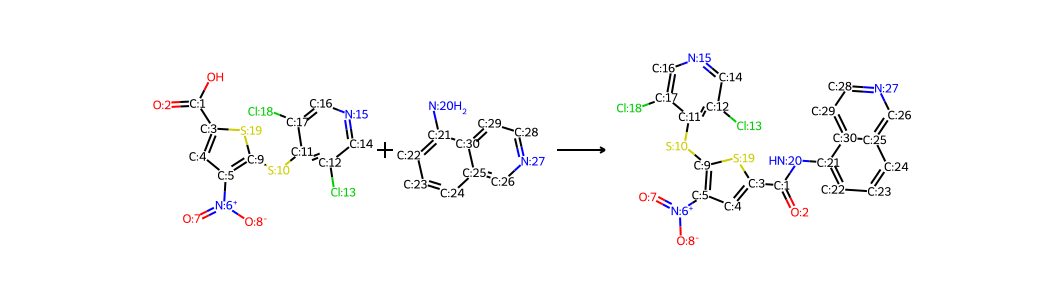

In [19]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (800,300)

rxn1 = rdChemReactions.ReactionFromSmarts(std_rxn_smiles, useSmiles=True)
rxn1

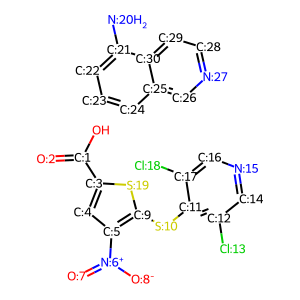

In [20]:
IPythonConsole.molSize = (300,300)
# Get the reactants
reactants = rxn1.GetReactants()
for reactant in reactants:
    Chem.SanitizeMol(reactant)
    
# combine the reactants in a single mol object
combined_reactants = reduce(Chem.CombineMols, reactants)
Chem.SanitizeMol(combined_reactants)
combined_reactants

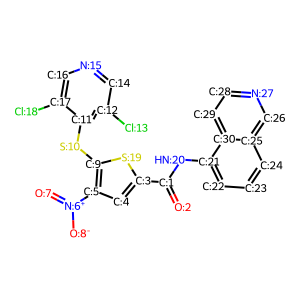

In [21]:
# Get the product
product = rxn1.GetProducts()[0]
Chem.SanitizeMol(product)
product

In [22]:
# compute fingerprints
reactant_fingerprint = AllChem.GetMorganFingerprint(combined_reactants, radius=2, useFeatures=True)
product_fingerprint = AllChem.GetMorganFingerprint(product, radius=2, useFeatures=True)

In [23]:
# extract templates
split_rxn = std_rxn_smiles = item1[1]['standardized_rxn'].split(">>")
reactant_smiles = split_rxn[0]
product_smiles = split_rxn[-1]

# We are using the rdchiral function extract_from_reaction with
# a speicifc dictionary input
template1 = extract_from_reaction({
    "reactants": reactant_smiles,
    "products": product_smiles,
    "_id": "test1"
    })

In [24]:
template1

{'products': '[#16;a:4]:[c:3]-[C;H0;D3;+0:1](=[O;D1;H0:2])-[NH;D2;+0:5]-[c:6]',
 'reactants': 'O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]:[#16;a:4].[NH2;D1;+0:5]-[c:6]',
 'reaction_smarts': '[#16;a:4]:[c:3]-[C;H0;D3;+0:1](=[O;D1;H0:2])-[NH;D2;+0:5]-[c:6]>>O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]:[#16;a:4].[NH2;D1;+0:5]-[c:6]',
 'intra_only': False,
 'dimer_only': False,
 'reaction_id': 'test1',
 'necessary_reagent': ''}

In [25]:
# Canonicalize the template reaction_smarts with rdcanon
canonical_template1 = canon_reaction_smarts(template1["reaction_smarts"], mapping=True)
canonical_template1

'[#16;a:4]:[c:3]-[C;D3;H0;+0:1](-[N;H1;D2;+0:5]-[c:6])=[O;D1;H0:2]>>[#16;a:4]:[c:3]-[C;D3;H0;+0:1](-[O])=[O;D1;H0:2].[N;H2;D1;+0:5]-[c:6]'

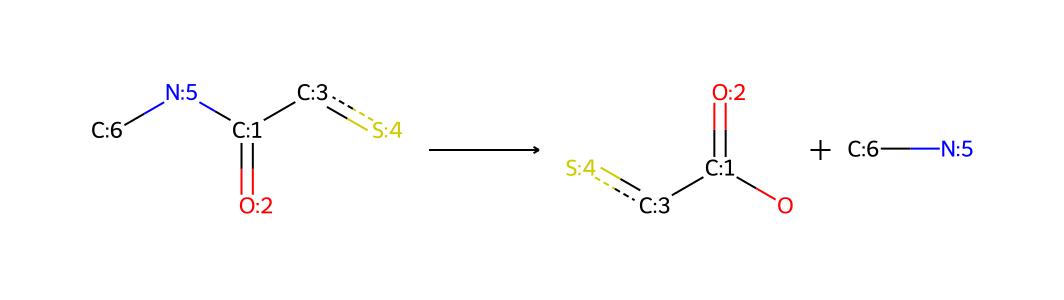

In [26]:
# Let's take a look at the template now
IPythonConsole.molSize = (800,300)
rxn_template1 = rdChemReactions.ReactionFromSmarts(canonical_template1)
rdChemReactions.SanitizeRxn(rxn_template1)
rxn_template1

In [27]:
# If we have an appropiate target mol, we can apply this template and predict a reaction
# PubChem CID:  9868037
# this is how to do that with RDChiral
target = rdchiralReactants('C1=CC=C2C(=C1)C(=CC=N2)CNC3=C(SC=C3)C(=O)NC4=CC=C(C=C4)OC(F)(F)F')
rxn_template1_rdc = rdchiralReaction(canonical_template1)
prediction1 = rdchiralRun(rxn_template1_rdc, target, combine_enantiomers=False)
prediction1

['Nc1ccc(OC(F)(F)F)cc1.O=C(O)c1sccc1NCc1ccnc2ccccc12']

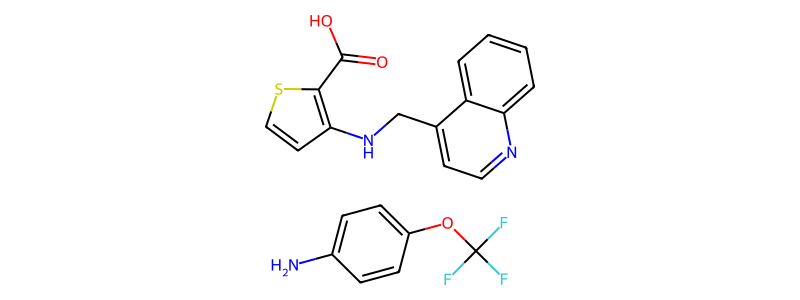

In [28]:
# View mols predicted
Chem.MolFromSmiles(prediction1[0])

In [29]:
# We can also use the built in RDKit RunReactants instead of rdchiral
target = Chem.MolFromSmiles('C1=CC=C2C(=C1)C(=CC=N2)CNC3=C(SC=C3)C(=O)NC4=CC=C(C=C4)OC(F)(F)F')
prediction1 = rxn_template1.RunReactants((target,)) # need to input reactants as tuples (in this case, only 1)
len(prediction1)

1

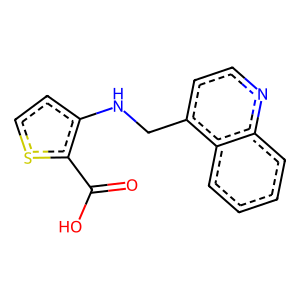

In [30]:
IPythonConsole.molSize = (300,300)
prediction1[0][0]

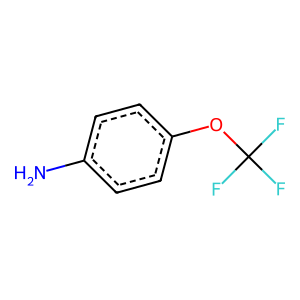

In [31]:
prediction1[0][1]

In [32]:
# Now put the steps for computing fingerprints and templates into a function

def process_reaction(item):
    """
    Steps:

    1. Check if reaction is valid
    2. Check if reactants are valid
    3. Check if agents are valid
    4. Check if products are valid
    5. Compute fingerprints
    6. Extract template
    7. Canonicalize template
    
    Returns:
    key: key of the reaction
    value: None if reaction is invalid, else a dictionary with the following keys:
    * rxn_class: reaction class
    * patent_id: patent id
    * rxn_smiles_mapping_name: reaction smiles
    * standardized_rxn: standardized reaction smiles
    * reactant_fingerprint: reactant fingerprint
    * product_fingerprint: product fingerprint
    * reactant_smiles: reactant smiles
    * product_smiles: product smiles
    * template_data: template data
    * canonical_template: canonical template
    """
    key, value = item
    reaction =  validate_reaction(key, value["standardized_rxn"])
    if not reaction:
        return key, None
    if not validate_reactants(key, reaction):
        return key, None
    if not validate_agents(key, reaction):
        return key, None
    if not validate_products(key, reaction):
        return key, None

    # Get the reactants
    reactants = reaction.GetReactants()
    for reactant in reactants:
        Chem.SanitizeMol(reactant)
    
    # combine the reactants in a single mol object
    combined_reactants = reduce(Chem.CombineMols, reactants)
    Chem.SanitizeMol(combined_reactants)

    # Get the product (at this point there is only 1)
    product = reaction.GetProducts()[0]
    Chem.SanitizeMol(product)

    # Compute fingerprints
    reactant_fingerprint = AllChem.GetMorganFingerprint(combined_reactants, radius=2, useFeatures=True)
    product_fingerprint = AllChem.GetMorganFingerprint(product, radius=2, useFeatures=True)

    # While the template calculations are not needed for the testing data,
    # we will run them through to remove improper reactions and guarantee a
    # Valid 80/20 dataset split later on
    split_rxn = value["standardized_rxn"].split(">>")
    reactant_smiles = split_rxn[0]
    product_smiles = split_rxn[-1]

    template = extract_from_reaction({
        "reactants": reactant_smiles,
        "products": product_smiles,
        "_id": key
    })

    # if template extraction fails
    if len(template.keys()) <= 1:
        return key, None
    
    reaction_smarts = template["reaction_smarts"]

    try:
       # try to canonicalize reaction smarts with rdcanon
       canonical_template = canon_reaction_smarts(reaction_smarts, mapping=True)
       template_reaction = rdChemReactions.ReactionFromSmarts(canonical_template)
    except Exception as e:
       print(f"Canon reaction failed on: {reaction_smarts}")
       # go back to original reaction_smarts (not canonical)
       canonical_template = reaction_smarts
       template_reaction = rdChemReactions.ReactionFromSmarts(canonical_template)

    # If template is generated with multiple reactants (so two target products in retrosynthesis)
    if len(template_reaction.GetReactants()) != 1:
        return key, None

    return key, {
        "rxn_class": value["rxn_class"],
        "patent_id": value["patent_id"],
        "rxn_smiles_mapping_name": value["rxn_smiles_mapping_name"],
        "standardized_rxn": value["standardized_rxn"],
        "reactant_fingerprint": reactant_fingerprint,
        "product_fingerprint": product_fingerprint,
        "reactant_smiles": reactant_smiles,
        "product_smiles": product_smiles,
        "template_data": template,
        "canonical_template": canonical_template
    }

In [33]:
# Show one example
# grab the keys and values
items = list(standardized_reactions.items())

In [34]:
items[1]

(2,
 {'rxn_class': '1',
  'patent_id': 'US08003648B2',
  'rxn_smiles_mapping_name': 'Cl.O=[CH:1][c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:24][CH2:25][C@@H:26]4[CH2:27][c:28]4[cH:29][cH:30][cH:31][cH:32][cH:33]4)[c:34]4[cH:35][cH:36][o:37][n:38]4)[cH:39][cH:40]3)[s:41]2)[cH:42][cH:43]1.[BH3-]C#N.[CH3:44][CH2:45][NH:46][CH2:47][CH3:48].[Na+]>>[CH2:1]([c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:24][CH2:25][C@@H:26]4[CH2:27][c:28]4[cH:29][cH:30][cH:31][cH:32][cH:33]4)[c:34]4[cH:35][cH:36][o:37][n:38]4)[cH:39][cH:40]3)[s:41]2)[cH:42][cH:43]1)[N:46]([CH2:45][CH3:44])[CH2:47][CH3:48]',
  'standardized_rxn': 'O=[CH:1][c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:2

In [35]:
# Process single reaction
process_reaction(items[1])

(2,
 {'rxn_class': '1',
  'patent_id': 'US08003648B2',
  'rxn_smiles_mapping_name': 'Cl.O=[CH:1][c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:24][CH2:25][C@@H:26]4[CH2:27][c:28]4[cH:29][cH:30][cH:31][cH:32][cH:33]4)[c:34]4[cH:35][cH:36][o:37][n:38]4)[cH:39][cH:40]3)[s:41]2)[cH:42][cH:43]1.[BH3-]C#N.[CH3:44][CH2:45][NH:46][CH2:47][CH3:48].[Na+]>>[CH2:1]([c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:24][CH2:25][C@@H:26]4[CH2:27][c:28]4[cH:29][cH:30][cH:31][cH:32][cH:33]4)[c:34]4[cH:35][cH:36][o:37][n:38]4)[cH:39][cH:40]3)[s:41]2)[cH:42][cH:43]1)[N:46]([CH2:45][CH3:44])[CH2:47][CH3:48]',
  'standardized_rxn': 'O=[CH:1][c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:2

In [36]:
# Processes all reactions and removes invalid reactions
# computes fingerprints and templates

if __name__ == "__main__":
    multiprocessing.set_start_method('fork', force=True)

    reaction_computations = {}
    items = list(standardized_reactions.items())

    with concurrent.futures.ProcessPoolExecutor(max_workers=max_cpus) as executor:
        results = list(executor.map(process_reaction, items))

    # Collect results
    for key, result in results:
        if result is not None:
           reaction_computations[key] = result

Canon reaction failed on: [O;D1;H0:5]=[C:4]-[c:3]:[c;H0;D3;+0:1](-[c;H0;D3;+0:6](:[c:7]):[c:8]):[c:2]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3]-[C:4]=[O;D1;H0:5].C-C(-C)(-C)-[Si](-C)(-C)-O-c1:c:c:c(-B2-O-B(-[c;H0;D3;+0:6](:[c:7]):[c:8])-O-B(-c3:c:c:c(-O-[Si](-C)(-C)-C(-C)(-C)-C):c:c:3)-O-2):c:c:1


In [37]:
len(reaction_computations)

48249

In [38]:
# Now we want to split the data into training and testing data
# We will use a 80/20 split
seed = 42

# Shuffle the items in place
items = list(reaction_computations.items())
random.seed(seed)
random.shuffle(items)

# 80% training, 20% testing
split_value = int(len(items) * 0.8)
training_data_items = items[:split_value]
testing_data_items = items[split_value:]

# Convert lists back to dictionaries
training_data = dict(training_data_items)
testing_data = dict(testing_data_items)

In [39]:
len(training_data), len(testing_data)

(38599, 9650)

In [40]:
# Remove unneccessary data from the testing dataset
# to avoid confusion
for key, value in testing_data.items():
    del value["template_data"]
    del value["canonical_template"]

In [41]:
list(training_data.items())[0]

(11746,
 {'rxn_class': '3',
  'patent_id': 'US08546376B2',
  'rxn_smiles_mapping_name': 'Br[c:1]1[cH:2][cH:3][c:4]([C:5]2([NH:6][C:7]([O:8][C:9]([CH3:10])([CH3:11])[CH3:12])=[O:13])[CH2:14][CH2:15][CH2:16]2)[cH:17][cH:18]1.C1COCCO1.CC(C)(C)P(C(C)(C)C)C(C)(C)C.CC(C)(C)P(C(C)(C)C)C(C)(C)C.CC(C)NC(C)C.I[Cu]I.[CH:19]#[C:20][c:21]1[cH:22][cH:23][cH:24][cH:25][cH:26]1.[Pd]>>[c:1]1([C:19]#[C:20][c:21]2[cH:22][cH:23][cH:24][cH:25][cH:26]2)[cH:2][cH:3][c:4]([C:5]2([NH:6][C:7]([O:8][C:9]([CH3:10])([CH3:11])[CH3:12])=[O:13])[CH2:14][CH2:15][CH2:16]2)[cH:17][cH:18]1',
  'standardized_rxn': 'Br[c:1]1[cH:2][cH:3][c:4]([C:5]2([NH:6][C:7]([O:8][C:9]([CH3:10])([CH3:11])[CH3:12])=[O:13])[CH2:14][CH2:15][CH2:16]2)[cH:17][cH:18]1.[CH:19]#[C:20][c:21]1[cH:22][cH:23][cH:24][cH:25][cH:26]1>>[c:1]1([C:19]#[C:20][c:21]2[cH:22][cH:23][cH:24][cH:25][cH:26]2)[cH:2][cH:3][c:4]([C:5]2([NH:6][C:7]([O:8][C:9]([CH3:10])([CH3:11])[CH3:12])=[O:13])[CH2:14][CH2:15][CH2:16]2)[cH:17][cH:18]1',
  'reactant_fingerprint': <rd

In [42]:
list(testing_data.items())[0]

(35118,
 {'rxn_class': '1',
  'patent_id': 'US07666866B2',
  'rxn_smiles_mapping_name': 'CN(C)C=O.I[CH2:1][CH3:2].O=C([O-])[O-].[CH3:3][O:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][c:13]1[OH:14].[K+].[K+]>>[CH2:1]([CH3:2])[O:11][c:10]1[cH:9][cH:8][c:7]([C:5]([O:4][CH3:3])=[O:6])[c:13]([OH:14])[cH:12]1',
  'standardized_rxn': 'I[CH2:1][CH3:2].[CH3:3][O:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][c:13]1[OH:14]>>[CH2:1]([CH3:2])[O:11][c:10]1[cH:9][cH:8][c:7]([C:5]([O:4][CH3:3])=[O:6])[c:13]([OH:14])[cH:12]1',
  'reactant_fingerprint': <rdkit.DataStructs.cDataStructs.UIntSparseIntVect at 0x7b99a1c1c770>,
  'product_fingerprint': <rdkit.DataStructs.cDataStructs.UIntSparseIntVect at 0x7b99a1c1c720>,
  'reactant_smiles': 'I[CH2:1][CH3:2].[CH3:3][O:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][c:13]1[OH:14]',
  'product_smiles': '[CH2:1]([CH3:2])[O:11][c:10]1[cH:9][cH:8][c:7]([C:5]([O:4][CH3:3])=[O:6])[c:13]([OH:14])[cH:12]1'})

In [43]:
# Get the distribution of rxn classes (see above for definitions)
def class_distribution(data):
    """
    Class measurements
    Loops through the data and prints out the class measurements via the rxn_class
    """
    classes = [0]*10

    for key, point in data.items():
        classes[int(point["rxn_class"])-1] += 1
    
    for class_, amount in enumerate(classes):
        print(class_+1, amount, f"{(amount/sum(classes)*100):.1f}%")


In [44]:
class_distribution(training_data)

1 11856 30.7%
2 9428 24.4%
3 4460 11.6%
4 705 1.8%
5 547 1.4%
6 5729 14.8%
7 3584 9.3%
8 648 1.7%
9 1453 3.8%
10 189 0.5%


In [45]:
class_distribution(testing_data)

1 2912 30.2%
2 2274 23.6%
3 1153 11.9%
4 186 1.9%
5 124 1.3%
6 1539 15.9%
7 905 9.4%
8 168 1.7%
9 347 3.6%
10 42 0.4%


## 4. Run Retrosynthesis Prediction Based on Similarity

**Model Workflow**

1. Get the target compound fingerprint (e.g., from the Test set)
2. Now, iterate through the training set product fingerprints, and compute the tanimoto similiary score of the products (S_prod)
3. Take the 100 most similar results (closer to 1.0)
4. Next, iterate through the reaction templates of the 100 most similar results and apply this reaction template to the target compound
        - some templates will produce candidate reactants, some will not produce any candidate reactants
5. Now for each candidate reactant set generated, compute the fingerprint and compare tanimoto similairy to the 100 original reaction reactant fingerprints (S_reac)
6. Compute an overall similarity of the predicted rxn, S_overall = S_prod x S_reac
7. Now, order the predicted reactions based on overall similarity (highest number == rank 1)
8. Remove any duplicate reaction predictions by comparing reactant canonical SMILES

In [46]:
# RDchiral version

# input is the test data (target)
def reaction_prediction(item):

    # 1. Get the target compound and fingerprint (from the test set)
    key, value = item
    target_product_fingerpint = value["product_fingerprint"]
    target_product = rdchiralReactants(value["product_smiles"])

    # 2. Iterate through the training set product fingerprints, and compute the tanimoto similarity score between target and products (S_prod)
    # Calculate similarities from training data
    training_data_similarities = {}
    for key2, value2 in training_data.items():
        training_product_fingerprint = value2["product_fingerprint"]
        similarity = AllChem.DataStructs.TanimotoSimilarity(target_product_fingerpint, training_product_fingerprint)
        training_data_similarities[key2] = similarity
    
    # 3. Take the 100 most similar results (closer to 1.0)
    # Sort by similarity
    training_data_similarities = sorted(training_data_similarities.items(), key=lambda x: x[1], reverse=True)

    # Grab top 100
    top_training_data_similarities = training_data_similarities[:100]

    # Grab associated training_data (e.g., reactions, templates, etc.) using the keys
    training_data_similaritiy_data = {
        key2: {
            "tanimoto_similarity": similarity,
            **training_data[key2], # could also index into reaction_computations instead
        }
        for key2, similarity in top_training_data_similarities
    }


    # 4. Next, iterate through the reaction templates of the 100 most similar results and apply this reaction template to the target compound
    # some templates will produce candidate reactants, some will not produce any candidate reactants

    prediction_lists = {}
    failed_and_duplicates = {}

    # Compare to templates
    for key2, training_data_item in training_data_similaritiy_data.items():
        rxn_template = rdchiralReaction(training_data_item["canonical_template"])
        precedent_reactant_fingerprint = training_data_item["reactant_fingerprint"]

        # 5. Now for each candidate reactant set generated/predicted, compute the fingerprint 
        # and compare tanimoto similarity to the 100 original reaction reactant fingerprints (S_reac)
        # For each template applied, if it produces multiple candidate sets, we grab the most similar one
        try:
            candidates = rdchiralRun(rxn_template, target_product, combine_enantiomers=False)
        except:
            failed_and_duplicates[key2] = {
                "template_applied": training_data_item["canonical_template"], #added here, but can also index the key later
                "predicted_candidate_smiles": "failed candidate sanitization",
                "reactant_smiles": "",
                "product_smiles": "",
                "predicted_reaction_smiles": "",
                "overall_similarity": 0.0,
                "candidate_similarity": 0.0,
                "product_similarity": 0.0,
                "rxn_class": value["rxn_class"],
                "failed_rxn": True,
                "duplicate_rxn": False
            }
            continue

        best_candidate_similarity = 0.0
        best_candidate_smiles = None
        
        for candidate in candidates:
            candidate_mol = Chem.MolFromSmiles(candidate)
            try:
                Chem.SanitizeMol(candidate_mol)
            except:
                continue
            candidate_fingerprint = AllChem.GetMorganFingerprint(candidate_mol, radius=2, useFeatures=True)
            candidate_similarity = AllChem.DataStructs.TanimotoSimilarity(candidate_fingerprint, precedent_reactant_fingerprint)
            if candidate_similarity > best_candidate_similarity:
                best_candidate_similarity = candidate_similarity
                best_candidate_smiles = candidate

        if best_candidate_smiles is None:
            failed_and_duplicates[key2] = {
                "template_applied": training_data_item["canonical_template"],
                "predicted_candidate_smiles": "failed candidate sanitization",
                "reactant_smiles": "",
                "product_smiles": "",
                "predicted_reaction_smiles": "",
                "overall_similarity": 0.0,
                "candidate_similarity": 0.0,
                "product_similarity": 0.0,
                "rxn_class": value["rxn_class"],
                "failed_rxn": True,
                "duplicate_rxn": False
            }
            continue

        # Reaction Smiles
        predicted_reaction_smiles = best_candidate_smiles + ">>" + remove_atom_mapping(value["product_smiles"])
    
        # Canonicalize the predicted reaction
        rxn = rdChemReactions.ReactionFromSmarts(predicted_reaction_smiles, useSmiles=True)
        rdChemReactions.SanitizeRxn(rxn)
        canonical_predicted_reaction_smiles = rdChemReactions.ReactionToSmiles(rxn)

        # 6. Compute an overall similarity of the predicted rxn, S_overall = S_prod x S_reac
        # Compare to original reactants

        # best_candidate_similarity = S_reac, training_data_item["tanimoto_similarity"] = S_prod
        overall_similarity = best_candidate_similarity * training_data_item["tanimoto_similarity"]
    
        prediction_lists[key2] = {
            "template_applied": training_data_item["canonical_template"],
            "predicted_candidate_smiles": best_candidate_smiles,
            "ground_truth_reactant_smiles": value["reactant_smiles"],
            "ground_truth_product_smiles": value["product_smiles"],
            "predicted_reaction_smiles": canonical_predicted_reaction_smiles,
            "overall_similarity": overall_similarity,
            "candidate_similarity": candidate_similarity,
            "product_similarity": training_data_item["tanimoto_similarity"],
            "rxn_class": value["rxn_class"],
            "failed_rxn": False,
            "duplicate_rxn": False
        }
    
    # 7. Now, order the predicted reactions based on overall similarity (highest number == rank 1)
    # sort by overall similarity
    prediction_lists = dict(sorted(prediction_lists.items(), key=lambda x: x[1]["overall_similarity"], reverse=True))

    # 8. Remove any duplicate reaction predictions by comparing reactant canonical SMILES
    # If duplicate predicted_candidate_smiles, mark as duplicate reaction by moving to failed_and_duplicates
    seen = set()
    for sub_key, sub_value in prediction_lists.items():
        if sub_value["predicted_candidate_smiles"] in seen:
            sub_value["duplicate_rxn"] = True  # Set duplicate flag to True
            failed_and_duplicates[sub_key] = sub_value
            # remove from prediction list
            prediction_lists[sub_key] = None
        else:
            seen.add(sub_value["predicted_candidate_smiles"])

    # Remove None values
    prediction_lists = {k: v for k, v in prediction_lists.items() if v is not None}

    if len(prediction_lists):
        return key, prediction_lists, failed_and_duplicates
    else:
        return key, None, failed_and_duplicates

In [47]:
# Grab the first item
item1 = list(testing_data.items())[0]
item1

(35118,
 {'rxn_class': '1',
  'patent_id': 'US07666866B2',
  'rxn_smiles_mapping_name': 'CN(C)C=O.I[CH2:1][CH3:2].O=C([O-])[O-].[CH3:3][O:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][c:13]1[OH:14].[K+].[K+]>>[CH2:1]([CH3:2])[O:11][c:10]1[cH:9][cH:8][c:7]([C:5]([O:4][CH3:3])=[O:6])[c:13]([OH:14])[cH:12]1',
  'standardized_rxn': 'I[CH2:1][CH3:2].[CH3:3][O:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][c:13]1[OH:14]>>[CH2:1]([CH3:2])[O:11][c:10]1[cH:9][cH:8][c:7]([C:5]([O:4][CH3:3])=[O:6])[c:13]([OH:14])[cH:12]1',
  'reactant_fingerprint': <rdkit.DataStructs.cDataStructs.UIntSparseIntVect at 0x7b99a1c1c770>,
  'product_fingerprint': <rdkit.DataStructs.cDataStructs.UIntSparseIntVect at 0x7b99a1c1c720>,
  'reactant_smiles': 'I[CH2:1][CH3:2].[CH3:3][O:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][c:13]1[OH:14]',
  'product_smiles': '[CH2:1]([CH3:2])[O:11][c:10]1[cH:9][cH:8][c:7]([C:5]([O:4][CH3:3])=[O:6])[c:13]([OH:14])[cH:12]1'})

In [48]:
# predict retrosynthesis from the product smiles in item1
# There will be 100 templates applied
predictions = reaction_prediction(item1)

In [49]:
# The succesful and unique predictions are at the 1st position
predictions[1]

{45480: {'template_applied': '[O;H0;D2;+0:3](-[c:4])-[C;H2;D2;+0:1]-[C:2]>>[O]-[C;H2;D2;+0:1]-[C:2].[O;D1;H1;+0:3]-[c:4]',
  'predicted_candidate_smiles': 'CCO.COC(=O)c1ccc(O)cc1O',
  'ground_truth_reactant_smiles': 'I[CH2:1][CH3:2].[CH3:3][O:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][c:10]([OH:11])[cH:12][c:13]1[OH:14]',
  'ground_truth_product_smiles': '[CH2:1]([CH3:2])[O:11][c:10]1[cH:9][cH:8][c:7]([C:5]([O:4][CH3:3])=[O:6])[c:13]([OH:14])[cH:12]1',
  'predicted_reaction_smiles': 'CCO.COC(=O)c1ccc(O)cc1O>>CCOc1ccc(C(=O)OC)c(O)c1',
  'overall_similarity': 0.5302457466918714,
  'candidate_similarity': 0.7391304347826086,
  'product_similarity': 0.717391304347826,
  'rxn_class': '1',
  'failed_rxn': False,
  'duplicate_rxn': False},
 22408: {'template_applied': '[O;D1;H1;+0:2]-[c:1]>>[O;H0;D2;+0:2](-[c:1])-[C]-[c]1(:[c]:[c]:[c]:[c]:[c]:1)',
  'predicted_candidate_smiles': 'CCOc1ccc(C(=O)OC)c(OCc2ccccc2)c1',
  'ground_truth_reactant_smiles': 'I[CH2:1][CH3:2].[CH3:3][O:4][C:5](=[O:6])[c:7]1[cH:8]

In [50]:
# failed and duplicate predictions are at position 2
# predictions[2]

In [51]:
print(len(predictions[1]))
print(len(predictions[2]))

11
89


Sequence 0
Similarity Scores: Overall: 0.5302457466918714,Candidate Reactants: 0.7391304347826086, Product: 0.717391304347826
Reaction Class: 1
Predicted Reaction: CCO.COC(=O)c1ccc(O)cc1O>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;H0;D2;+0:3](-[c:4])-[C;H2;D2;+0:1]-[C:2]>>[O]-[C;H2;D2;+0:1]-[C:2].[O;D1;H1;+0:3]-[c:4]
Patent ID: US20100041892A1
Ground Truth Does Not Equal Prediction


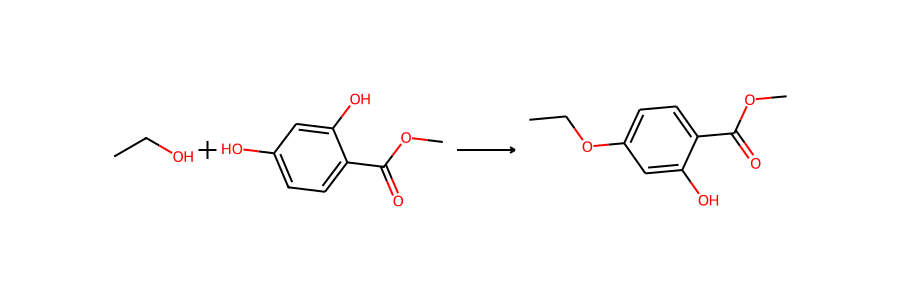

--------------------------------------------



Sequence 1
Similarity Scores: Overall: 0.447887323943662,Candidate Reactants: 0.7464788732394366, Product: 0.6
Reaction Class: 1
Predicted Reaction: CCOc1ccc(C(=O)OC)c(OCc2ccccc2)c1>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;D1;H1;+0:2]-[c:1]>>[O;H0;D2;+0:2](-[c:1])-[C]-[c]1(:[c]:[c]:[c]:[c]:[c]:1)
Patent ID: US20110098290A1
Ground Truth Does Not Equal Prediction


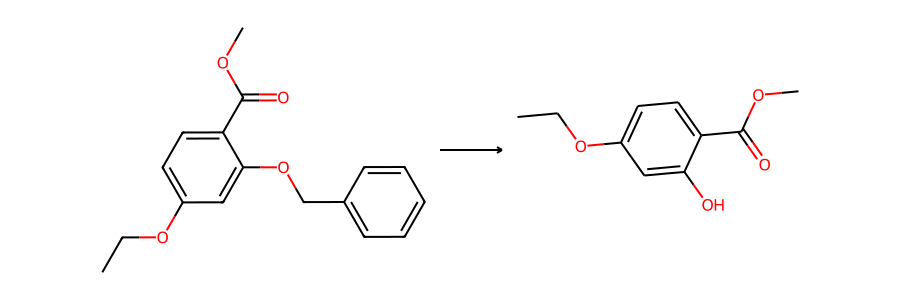

--------------------------------------------



Sequence 2
Similarity Scores: Overall: 0.4301572617946346,Candidate Reactants: 0.6739130434782609, Product: 0.6382978723404256
Reaction Class: 1
Predicted Reaction: CCBr.COC(=O)c1ccc(O)cc1O>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;H0;D2;+0:3](-[c:4])-[C;H2;D2;+0:1]-[C:2]>>[Br]-[C;H2;D2;+0:1]-[C:2].[O;D1;H1;+0:3]-[c:4]
Patent ID: US20150202332A1
Ground Truth Does Not Equal Prediction


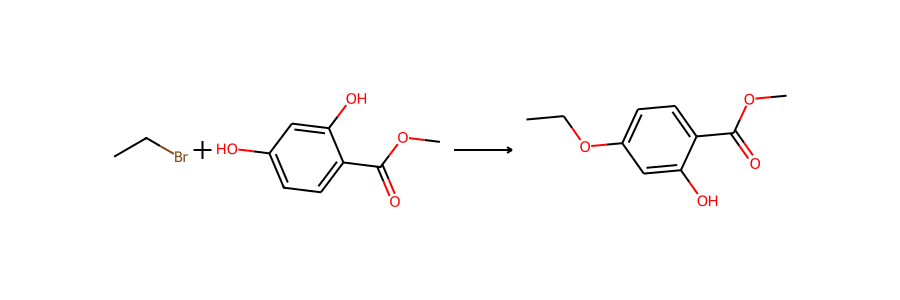

--------------------------------------------



Sequence 3
Similarity Scores: Overall: 0.4171006944444445,Candidate Reactants: 0.6458333333333334, Product: 0.6458333333333334
Reaction Class: 1
Predicted Reaction: CCI.COC(=O)c1ccc(O)cc1O>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;H0;D2;+0:3](-[c:4])-[C;H2;D2;+0:1]-[C;H3;D1:2]>>[I]-[C;H2;D2;+0:1]-[C;H3;D1:2].[O;D1;H1;+0:3]-[c:4]
Patent ID: US20080249137A1
Ground Truth Equals Prediction


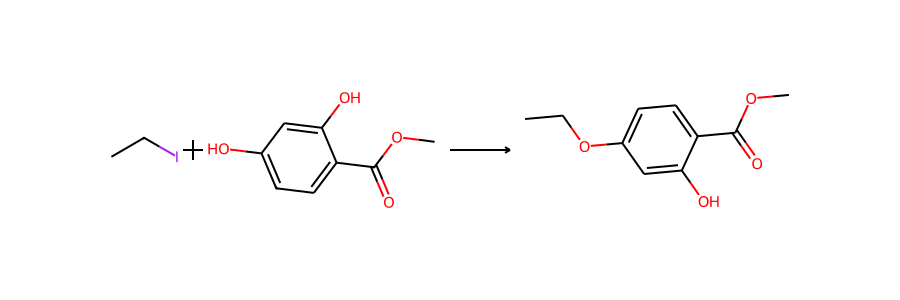

--------------------------------------------



Sequence 4
Similarity Scores: Overall: 0.4104938271604939,Candidate Reactants: 0.7037037037037037, Product: 0.5833333333333334
Reaction Class: 1
Predicted Reaction: CCOc1ccc(C(=O)OC)c(OC(C)=O)c1>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;D1;H1;+0:1]-[c:2]>>[O]=[C](-[O;H0;D2;+0:1]-[c:2])-[C]
Patent ID: US20100197950A1
Ground Truth Does Not Equal Prediction


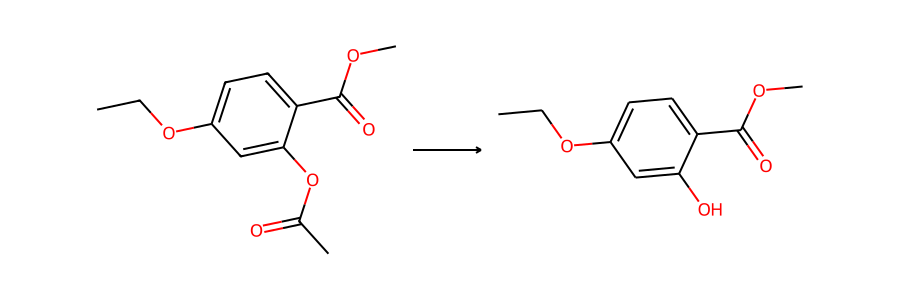

--------------------------------------------



Sequence 5
Similarity Scores: Overall: 0.35491172476233585,Candidate Reactants: 0.5957446808510638, Product: 0.5957446808510638
Reaction Class: 1
Predicted Reaction: CCOc1ccc(C(=O)O)c(O)c1.CO>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;D1;H0:2]=[C:3]-[O;H0;D2;+0:4]-[C;H3;D1;+0:1]>>[O]-[C;H3;D1;+0:1].[O;D1;H1;+0:4]-[C:3]=[O;D1;H0:2]
Patent ID: US20060287291A1
Ground Truth Does Not Equal Prediction


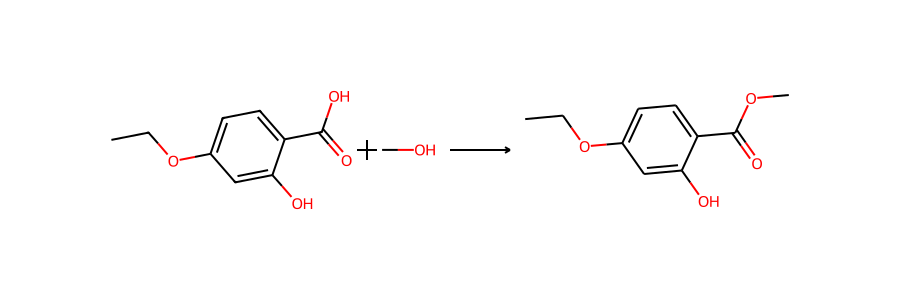

--------------------------------------------



Sequence 6
Similarity Scores: Overall: 0.3439349112426035,Candidate Reactants: 0.5961538461538461, Product: 0.5769230769230769
Reaction Class: 1
Predicted Reaction: CCCl.COC(=O)c1ccc(O)cc1O>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;H0;D2;+0:3](-[c:4])-[C;H2;D2;+0:1]-[C:2]>>[Cl]-[C;H2;D2;+0:1]-[C:2].[O;D1;H1;+0:3]-[c:4]
Patent ID: US06069149
Ground Truth Does Not Equal Prediction


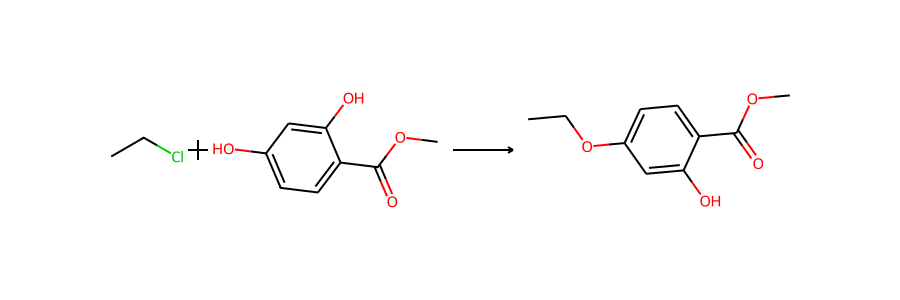

--------------------------------------------



Sequence 7
Similarity Scores: Overall: 0.33239766081871347,Candidate Reactants: 0.6533333333333333, Product: 0.5087719298245614
Reaction Class: 1
Predicted Reaction: CCOc1ccc(C(=O)OC)c(OC2CCCCO2)c1>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;D1;H1;+0:2]-[c:1]>>[O]1(-[C](-[O;H0;D2;+0:2]-[c:1])-[C]-[C]-[C]-[C]-1)
Patent ID: US08030354B2
Ground Truth Does Not Equal Prediction


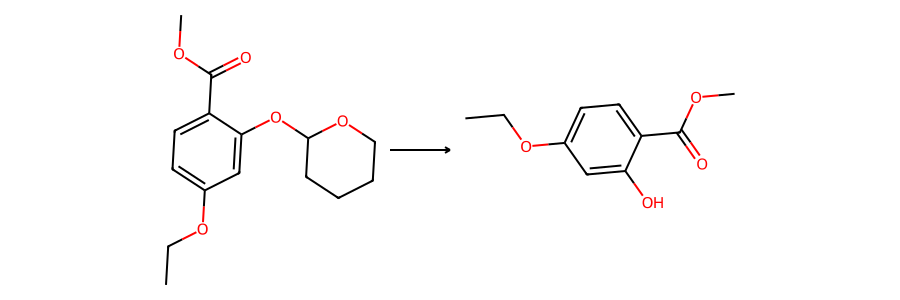

--------------------------------------------



Sequence 8
Similarity Scores: Overall: 0.2894736842105263,Candidate Reactants: 0.5789473684210527, Product: 0.5
Reaction Class: 1
Predicted Reaction: CCOc1ccc(C(=O)OC)c(OCOC)c1>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;D1;H1;+0:1]-[c:2]>>[O](-[C]-[O;H0;D2;+0:1]-[c:2])-[C]
Patent ID: US20130267510A1
Ground Truth Does Not Equal Prediction


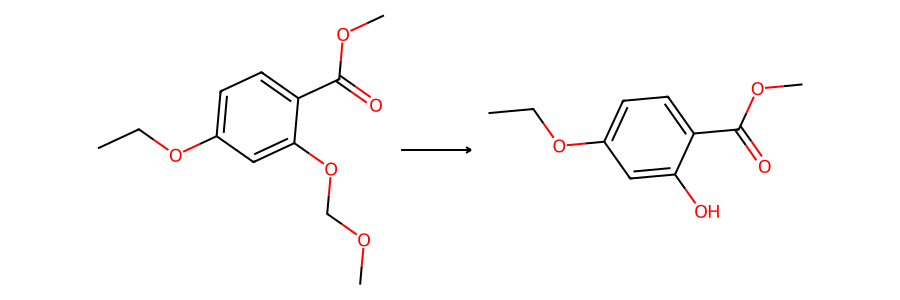

--------------------------------------------



Sequence 9
Similarity Scores: Overall: 0.28452830188679246,Candidate Reactants: 0.5471698113207547, Product: 0.52
Reaction Class: 1
Predicted Reaction: CCOc1ccc(C(=O)OC)c(OC)c1>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;D1;H1;+0:1]-[c:2]>>[O;H0;D2;+0:1](-[c:2])-[C]
Patent ID: US20120022075A1
Ground Truth Does Not Equal Prediction


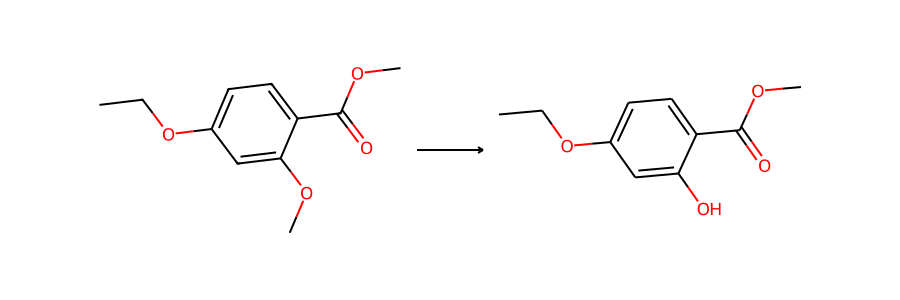

--------------------------------------------



Sequence 10
Similarity Scores: Overall: 0.2686106346483705,Candidate Reactants: 0.5272727272727272, Product: 0.5094339622641509
Reaction Class: 1
Predicted Reaction: CCOc1cc(O)c(C(=O)OC)c(Br)c1>>CCOc1ccc(C(=O)OC)c(O)c1
Template Applied: [O;D1;H0:6]=[C:4](-[#8:5])-[c:3]:[c;H1;D2;+0:1]:[c:2]>>[Br]-[c;D3;H0;+0:1](:[c:2]):[c:3]-[C:4](=[O;D1;H0:6])-[#8:5]
Patent ID: US20100305093A1
Ground Truth Does Not Equal Prediction


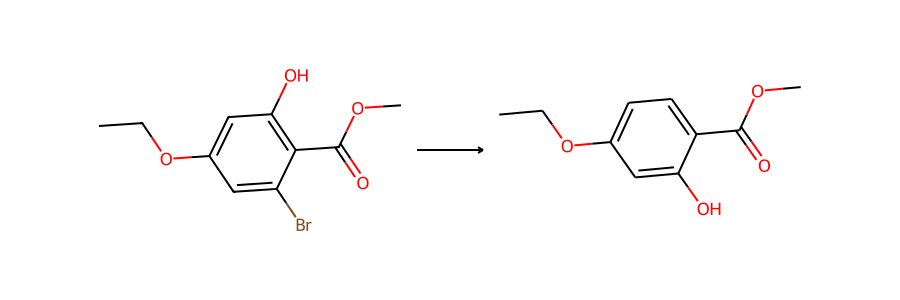

--------------------------------------------





In [52]:
# visualize the unique predicted reactions and compare to "ground truth"
for idx, (key, sequence) in enumerate(predictions[1].items()):
    print("Sequence " + str(idx))
    print(f"Similarity Scores: Overall: {sequence['overall_similarity']},Candidate Reactants: {sequence['candidate_similarity']}, Product: {sequence['product_similarity']}")
    print(f"Reaction Class: {sequence['rxn_class']}")
    print(f"Predicted Reaction: {sequence['predicted_reaction_smiles']}")
    print(f"Template Applied: {training_data[key]['canonical_template']}")
    print(f"Patent ID: {training_data[key]['patent_id']}")

    ground_truth_reactant_smiles = remove_atom_mapping(sequence["ground_truth_reactant_smiles"])
    
    predicted_candidate_smile = remove_atom_mapping(sequence["predicted_candidate_smiles"])
    
    # ANSI escape codes for colors
    NEON_GREEN = "\033[92m"
    RED = "\033[91m"
    RESET = "\033[0m"

    if predicted_candidate_smile == ground_truth_reactant_smiles:
       print(f"{NEON_GREEN}Ground Truth Equals Prediction{RESET}")
    else:
       print(f"{RED}Ground Truth Does Not Equal Prediction{RESET}")

    # Draw reaction with RDKit using rdMolDraw2D module
    rxn_smiles = sequence['predicted_reaction_smiles']
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles, useSmiles=True)
    rdChemReactions.SanitizeRxn(rxn)
    drawer = rdMolDraw2D.MolDraw2DSVG(900, 300)
    drawer.drawOptions().addStereoAnnotation = False
    drawer.DrawReaction(rxn, highlightByReactant=False)
    drawer.FinishDrawing()
    display(SVG(drawer.GetDrawingText()))

    print('--------------------------------------------\n\n\n')
    if idx >= 15:
        break

In [53]:
# Process all testing data targets! (predict 9650 reactions)
# This takes about 5 minutes on my workstation using 12 CPUs

if __name__ == "__main__":
    multiprocessing.set_start_method('fork', force=True)

    items = list(testing_data.items())

    with concurrent.futures.ProcessPoolExecutor(max_workers=max_cpus) as executor:
        results = list(executor.map(reaction_prediction, testing_data.items()))

In [54]:
# look at one of the targets
list(testing_data.items())[5]

(8270,
 {'rxn_class': '1',
  'patent_id': 'US07893058B2',
  'rxn_smiles_mapping_name': 'Br[c:1]1[cH:2][n:3][c:4]([N:5]([C:6]([O:7][C:8]([CH3:9])([CH3:10])[CH3:11])=[O:12])[c:13]2[cH:14][cH:15][c:16]([N:17]3[CH2:18][CH2:19][O:20][CH2:21][CH2:22]3)[cH:23][cH:24]2)[c:25]2[n:26]1[cH:27][cH:28][n:29]2.C1CCOC1.CC(C)[Mg+].Cl[Sn:30]([CH2:31][CH2:32][CH2:33][CH3:34])([CH2:35][CH2:36][CH2:37][CH3:38])[CH2:39][CH2:40][CH2:41][CH3:42].[Cl-]>>[c:1]1([Sn:30]([CH2:31][CH2:32][CH2:33][CH3:34])([CH2:35][CH2:36][CH2:37][CH3:38])[CH2:39][CH2:40][CH2:41][CH3:42])[cH:2][n:3][c:4]([N:5]([C:6]([O:7][C:8]([CH3:9])([CH3:10])[CH3:11])=[O:12])[c:13]2[cH:14][cH:15][c:16]([N:17]3[CH2:18][CH2:19][O:20][CH2:21][CH2:22]3)[cH:23][cH:24]2)[c:25]2[n:26]1[cH:27][cH:28][n:29]2',
  'standardized_rxn': 'Br[c:1]1[cH:2][n:3][c:4]([N:5]([C:6]([O:7][C:8]([CH3:9])([CH3:10])[CH3:11])=[O:12])[c:13]2[cH:14][cH:15][c:16]([N:17]3[CH2:18][CH2:19][O:20][CH2:21][CH2:22]3)[cH:23][cH:24]2)[c:25]2[n:26]1[cH:27][cH:28][n:29]2.Cl[Sn:30]([CH2

In [55]:
prediction_8270 = results[5]

In [56]:
# The succesful and unique predictions are at the 1st position
prediction_8270[1]

{46191: {'template_applied': '[N;D3;H0;+0:5](-[c;D3;H0;+0:1](:[c:2]):[c:3])(-[C:4])-[C:6]>>[F]-[c;D3;H0;+0:1](:[c:2]):[c:3].[N;H1;D2;+0:5](-[C:4])-[C:6]',
  'predicted_candidate_smiles': 'C1COCCN1.CCCC[Sn](CCCC)(CCCC)c1cnc(N(C(=O)OC(C)(C)C)c2ccc(F)cc2)c2nccn12',
  'ground_truth_reactant_smiles': 'Br[c:1]1[cH:2][n:3][c:4]([N:5]([C:6]([O:7][C:8]([CH3:9])([CH3:10])[CH3:11])=[O:12])[c:13]2[cH:14][cH:15][c:16]([N:17]3[CH2:18][CH2:19][O:20][CH2:21][CH2:22]3)[cH:23][cH:24]2)[c:25]2[n:26]1[cH:27][cH:28][n:29]2.Cl[Sn:30]([CH2:31][CH2:32][CH2:33][CH3:34])([CH2:35][CH2:36][CH2:37][CH3:38])[CH2:39][CH2:40][CH2:41][CH3:42]',
  'ground_truth_product_smiles': '[c:1]1([Sn:30]([CH2:31][CH2:32][CH2:33][CH3:34])([CH2:35][CH2:36][CH2:37][CH3:38])[CH2:39][CH2:40][CH2:41][CH3:42])[cH:2][n:3][c:4]([N:5]([C:6]([O:7][C:8]([CH3:9])([CH3:10])[CH3:11])=[O:12])[c:13]2[cH:14][cH:15][c:16]([N:17]3[CH2:18][CH2:19][O:20][CH2:21][CH2:22]3)[cH:23][cH:24]2)[c:25]2[n:26]1[cH:27][cH:28][n:29]2',
  'predicted_reaction_smile

In [57]:
# Failed and duplicates at second position
# prediction_8270[2]

In [58]:
# Collect results and get number of predicted rxns

prediction_data = {}
failed_and_duplicates_data = {}
for key, result, fails in results:
    if result is not None:
        prediction_data[key] = result
    if fails is not None:
        failed_and_duplicates_data[key] = fails


print(f"Number of rxns in prediction list: {len(prediction_data)}")
print(f"Number of entries in failed_and_duplicates: {len(failed_and_duplicates_data)}")

Number of rxns in prediction list: 9607
Number of entries in failed_and_duplicates: 9650


In [59]:
prediction_data[8270]

{46191: {'template_applied': '[N;D3;H0;+0:5](-[c;D3;H0;+0:1](:[c:2]):[c:3])(-[C:4])-[C:6]>>[F]-[c;D3;H0;+0:1](:[c:2]):[c:3].[N;H1;D2;+0:5](-[C:4])-[C:6]',
  'predicted_candidate_smiles': 'C1COCCN1.CCCC[Sn](CCCC)(CCCC)c1cnc(N(C(=O)OC(C)(C)C)c2ccc(F)cc2)c2nccn12',
  'ground_truth_reactant_smiles': 'Br[c:1]1[cH:2][n:3][c:4]([N:5]([C:6]([O:7][C:8]([CH3:9])([CH3:10])[CH3:11])=[O:12])[c:13]2[cH:14][cH:15][c:16]([N:17]3[CH2:18][CH2:19][O:20][CH2:21][CH2:22]3)[cH:23][cH:24]2)[c:25]2[n:26]1[cH:27][cH:28][n:29]2.Cl[Sn:30]([CH2:31][CH2:32][CH2:33][CH3:34])([CH2:35][CH2:36][CH2:37][CH3:38])[CH2:39][CH2:40][CH2:41][CH3:42]',
  'ground_truth_product_smiles': '[c:1]1([Sn:30]([CH2:31][CH2:32][CH2:33][CH3:34])([CH2:35][CH2:36][CH2:37][CH3:38])[CH2:39][CH2:40][CH2:41][CH3:42])[cH:2][n:3][c:4]([N:5]([C:6]([O:7][C:8]([CH3:9])([CH3:10])[CH3:11])=[O:12])[c:13]2[cH:14][cH:15][c:16]([N:17]3[CH2:18][CH2:19][O:20][CH2:21][CH2:22]3)[cH:23][cH:24]2)[c:25]2[n:26]1[cH:27][cH:28][n:29]2',
  'predicted_reaction_smile

In [60]:
# failed_and_duplicates_data[8270]

## 5. Evaluation of Model

We want to reproduce Tables 2 and 3 in https://pubs.acs.org/doi/10.1021/acscentsci.7b00355

1. To do this, we need to run every target compound in the test set through the prediction workflow.
2. Then, compare the top 100 predicted reactions to the ground truth (known reaction SMILES in test dataset)
        - remove atom mapping first, compare canonical smiles of predicted vs. ground truth
3. The top n predictions are then if the ground truth reaction was found in top 1%, 3%, 5%, etc of the ranked ordered list of predicted reactions.
4. First without specifying a reaction class, but then also filtering and specifying a reaction class (e.g., if the predicted rxn is in class 2, only apply class 2 templates)

In [61]:
def check_prediction(item):
    """
    Steps:
    Check if the prediction matches ground truth reactant smiles to the predicted candidate smiles
    Returns:
    key: key of the reaction
    value: dictionary with the following
    * Ground Truth Equals Prediction: True if the prediction matches, False otherwise
    """
    key, prediction_lists = item
    ground_truth_reactant_smiles = remove_atom_mapping(prediction_lists[list(prediction_lists.keys())[0]]["ground_truth_reactant_smiles"])
    
    for key2, specific_prediction in prediction_lists.items():
        predicted_candidate_smile = remove_atom_mapping(specific_prediction["predicted_candidate_smiles"])

        # compare the canonical SMILES
        if predicted_candidate_smile == ground_truth_reactant_smiles:
            prediction_lists[key2]["Ground Truth Equals Prediction"] = True
        else:
            prediction_lists[key2]["Ground Truth Equals Prediction"] = False
    return key, prediction_lists

In [62]:
# Run through all of them...

if __name__ == "__main__":
    multiprocessing.set_start_method('fork', force=True)

    items = list(prediction_data.items())

    with concurrent.futures.ProcessPoolExecutor(max_workers=max_cpus) as executor:
        results = list(executor.map(check_prediction, items))

    # Collect results
    prediction_data_list = {}
    for key, result in results:
        prediction_data_list[key] = result

print(f"Number of entries in successful_prediction_list: {len(prediction_data_list)}")    

Number of entries in successful_prediction_list: 9607


In [63]:
top_1, top_3, top_5, top_10, top_20, top_50  = 0, 0, 0, 0, 0, 0

for prediction_item in prediction_data_list.values():
    for idx, value in enumerate(prediction_item.values()):
        if value["Ground Truth Equals Prediction"]:
            break
    if idx < 1:
        top_1 += 1
    if idx < 3:
        top_3 += 1
    if idx < 5:
        top_5 += 1
    if idx < 10:
        top_10 += 1
    if idx < 20:
        top_20 += 1
    if idx < 50:
        top_50 += 1

In [64]:
# 100 % with rounding to nearest decimal
valid_prediction_counts = len(prediction_data_list)
print(f"Top 1: {(top_1 *100) / valid_prediction_counts:.1f}%")
print(f"Top 3: {(top_3 *100) / valid_prediction_counts:.1f}%")
print(f"Top 5: {(top_5 *100) / valid_prediction_counts:.1f}%")
print(f"Top 10: {(top_10 *100) / valid_prediction_counts:.1f}%")
print(f"Top 20: {(top_20 *100) / valid_prediction_counts:.1f}%")
print(f"Top 50: {(top_50 *100) / valid_prediction_counts:.1f}%")

Top 1: 39.3%
Top 3: 63.7%
Top 5: 77.8%
Top 10: 95.5%
Top 20: 100.0%
Top 50: 100.0%


### Self-Study/Bonus Content

In [65]:
#######
#######
#######
#######
####### 
#######
#######
#######

## If you wish to use rdkit.Runreactants() instead of the rdchiral code to run and apply reaction templates.

# 1. Run this block instead of the rdchiral block for reaction_prediction()
# 2. Comment out the rdchiral block
# 3. Run Whole Notebook

def reaction_prediction(item):

    # 1. Get the target compound and fingerprint (from the test set)
    key, value = item
    target_product_fingerpint = value["product_fingerprint"]
    target_product = Chem.MolFromSmiles(value["product_smiles"])

    # 2. Iterate through the training set product fingerprints, and compute the tanimoto similiary score between target and products (S_prod)
    # Calculate similarities from training data
    training_data_similarities = {}
    for key2, value2 in training_data.items():
        training_product_fingerprint = value2["product_fingerprint"]
        similarity = AllChem.DataStructs.TanimotoSimilarity(target_product_fingerpint, training_product_fingerprint)
        training_data_similarities[key2] = similarity
    
    # 3. Take the 100 most similar results (closer to 1.0)
    # Sort by similarity
    training_data_similarities = sorted(training_data_similarities.items(), key=lambda x: x[1], reverse=True)

    # Grab top 100
    top_training_data_similarities = training_data_similarities[:100]

    # Grab training_data using the keys
    training_data_similaritiy_data = {
        key2: {
            "tanimoto_similarity": similarity,
            **training_data[key2], # could also index into reaction_computations instead
        }
        for key2, similarity in top_training_data_similarities
    }

    # 4. Next, iterate through the reaction templates of the 100 most similar results and apply this reaction template to the target compound
    # some templates will produce candidate reactants, some will not produce any candidate reactants

    prediction_lists = {}
    failed_and_duplicates = {}

    # Compare to templates
    for key2, training_data_item in training_data_similaritiy_data.items():
        rxn_template = rdChemReactions.ReactionFromSmarts(training_data_item["canonical_template"])
        rdChemReactions.SanitizeRxn(rxn_template)
        precedent_reactant_fingerprint = training_data_item["reactant_fingerprint"]
        
        # 5. Now for each candidate reactant set generated, compute the fingerprint 
        # and compare tanimoto similarity to the 100 original reaction reactant fingerprints (S_reac)
        # For each template applied, if it produces multiple candidate sets, we grab the most similar one
        try:
            candidates = rxn_template.RunReactants((target_product,))
        except:
            failed_and_duplicates[key2] = {
                "predicted_candidate_smiles": "failed candidate sanitization",
                "reactant_smiles": "",
                "product_smiles": "",
                "predicted_reaction_smiles": "",
                "overall_similarity": 0.0,
                "candidate_similarity": 0.0,
                "product_similarity": 0.0,
                "rxn_class": value["rxn_class"],
                "failed_rxn": True,
                "duplicate_rxn": False
            }
            continue

        best_candidate_similarity = 0.0
        best_candidate_smiles = None
        for candidate in candidates:
            failed = 1
            for candidate_reactant in candidate:
                try:
                    Chem.SanitizeMol(candidate_reactant)
                except:
                    break
            else:
                failed = 0
            if failed:
                continue

            candidate_reactants = reduce(Chem.CombineMols, candidate)
            Chem.SanitizeMol(candidate_reactants)
            candidate_fingerprint = AllChem.GetMorganFingerprint(candidate_reactants, radius=2, useFeatures=True)

            candidate_similarity = AllChem.DataStructs.TanimotoSimilarity(candidate_fingerprint, precedent_reactant_fingerprint)
            if candidate_similarity > best_candidate_similarity:
                best_candidate_similarity = candidate_similarity
                best_candidate_smiles = Chem.MolToSmiles(candidate_reactants)

        if best_candidate_smiles is None:
            failed_and_duplicates[key2] = {
                "predicted_candidate_smiles": "failed candidate sanitization",
                "reactant_smiles": "",
                "product_smiles": "",
                "predicted_reaction_smiles": "",
                "overall_similarity": 0.0,
                "candidate_similarity": 0.0,
                "product_similarity": 0.0,
                "rxn_class": value["rxn_class"],
                "failed_rxn": True,
                "duplicate_rxn": False
            }
            continue

        # Reaction Smiles
        predicted_reaction_smiles = best_candidate_smiles + ">>" + value["product_smiles"]
    
        # Canonicalize the predicted reaction
        rxn = rdChemReactions.ReactionFromSmarts(predicted_reaction_smiles, useSmiles=True)
        rdChemReactions.SanitizeRxn(rxn)
        canonical_predicted_reaction_smiles = rdChemReactions.ReactionToSmiles(rxn)

        # 6. Compute an overall similarity of the predicted rxn, S_overall = S_prod x S_reac
        # Compare to original reactants
        overall_similarity = best_candidate_similarity * training_data_item["tanimoto_similarity"]
    
        prediction_lists[key2] = {
            "predicted_candidate_smiles": best_candidate_smiles,
            "ground_truth_reactant_smiles": value["reactant_smiles"],
            "ground_truth_product_smiles": value["product_smiles"],
            "predicted_reaction_smiles": canonical_predicted_reaction_smiles,
            "overall_similarity": overall_similarity,
            "candidate_similarity": candidate_similarity,
            "product_similarity": training_data_item["tanimoto_similarity"],
            "rxn_class": value["rxn_class"],
            "failed_rxn": False,
            "duplicate_rxn": False
        }
    
    # 7. Now, order the predicted reactions based on overall similarity (highest number == rank 1)
    # sort by overall similarity
    prediction_lists = dict(sorted(prediction_lists.items(), key=lambda x: x[1]["overall_similarity"], reverse=True))

    # If duplicate predicted_candidate_smiles, mark as duplicate reaction by moving to failed_and_duplicates
    seen = set()
    for sub_key, sub_value in prediction_lists.items():
        if sub_value["predicted_candidate_smiles"] in seen:
            sub_value["duplicate_rxn"] = True  # Set duplicate flag to True
            failed_and_duplicates[sub_key] = sub_value
            # remove from prediction_lists
            prediction_lists[sub_key] = None
        else:
            seen.add(sub_value["predicted_candidate_smiles"])

    # Remove None values
    prediction_lists = {k: v for k, v in prediction_lists.items() if v is not None}

    if len(prediction_lists):
        return key, prediction_lists, failed_and_duplicates
    else:
        return key, None, failed_and_duplicates